In [ ]:
##Instalar librerias necesarias

!pip install ultralytics opencv-python-headless scikit-learn pillow matplotlib --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install ultralytics opencv-python-headless scikit-learn pillow matplotlib seaborn --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install -q ultralytics roboflow
!pip install git+https://github.com/openai/CLIP.git --quiet


import os
import cv2
import numpy as np
from PIL import Image
import torch
from sklearn.cluster import KMeans
from google.colab import files
from google.colab.patches import cv2_imshow
import clip
from collections import Counter
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 99.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
"""
En este apartado se decarga el dataset que se va a utilizar para el entrenamiento de el modelo que se va a utilizar.

"""

from roboflow import Roboflow
rf = Roboflow(api_key="u3gAiIaGdFbqRayv2IEP")
project = rf.workspace("sm-p4e11").project("football-g1yzd")
version = project.version(7)
dataset = version.download("yolov11")

In [ ]:
from ultralytics import YOLO
import os

!yolo task=detect mode=train model=yolo11x.pt data=/content/Football-7/data.yaml batch=6 epochs=20 imgsz=960 plots=True

TRAINED_MODEL_PATH = "runs/detect/football_detector/weights/best.pt"

In [ ]:
from IPython.display import Image

Image('/content/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
##Configuracion, subir imagenes y crear una carpeta

"""
Esta sección se encarga de crear un directorio en el que se guardarán las imagenes que se van a utilizar, las imagenes
se cargan desde el computador, convierte las imagenes a PNG para tener una mejor consistencia y posteriormente limpia
la carpeta en caso de que haya archivos viejos existentes.
"""



os.makedirs("/content/images", exist_ok=True)
print("\nSube tus imágenes:")
uploaded = files.upload()


for existing_file in os.listdir("/content/images"):
    os.remove(f"/content/images/{existing_file}")

for name in uploaded.keys():
    path = f"/content/images/{name}"
    os.rename(name, path)
    img = Image.open(path).convert("RGB")
    new_name = f"/content/images/{os.path.splitext(name)[0]}.png"
    img.save(new_name)
    if path != new_name:
        os.remove(path)

print(f" {len(uploaded)} imagen(es) cargada(s) correctamente\n")


Sube tus imágenes:


Saving ImagenPrueba2.webp to ImagenPrueba2.webp
 1 imagen(es) cargada(s) correctamente



In [ ]:
# Preprocesamiento de las imagenes

"""
Esta clase mejora la calidad de las imágenes antes del análisis y utiliza algunas funciones para llevar esto acabo:

- El metodo enhance_adaptive(): Analiza la imagen y aplica mejoras según sea necesario, este puede
aplicar un filtro bilateral, un CLAHE o un ajuste de brillo.

- La función show_comparison() crea una visualización lado a lado de la imagen
  original vs la procesada para que se puedan observar las mejoras
"""


class ImagePreprocessor:
    @staticmethod
    def enhance_adaptive(frame):

        # Convertir a escala de grises para análisis de calidad
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular métricas de calidad de imagen
        mean_brightness = np.mean(gray)
        std_brightness = np.std(gray)

        # Primer Caso: Imagen con calidad aceptable
        # Condiciones: Brillo entre 100-180 y contraste decente (std > 40)
        if 100 < mean_brightness < 180 and std_brightness > 40:
            print("Imagen con buena calidad, sin preprocesamiento")
            return frame

        enhanced = frame.copy()

        # Segundo Caso: Alto ruido detectado (std > 60)
        # Solución: Filtro bilateral para suavizar ruido preservando bordes
        if std_brightness > 60:
            enhanced = cv2.bilateralFilter(enhanced, 5, 50, 50)


        # Tercer Caso: Bajo contraste (std < 40)
        # Solución: CLAHE (Contrast Limited Adaptive Histogram Equalization)
        # Mejora contraste local sin amplificar ruido
        if std_brightness < 40:
            lab = cv2.cvtColor(enhanced, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            enhanced = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2BGR)


        # Cuarto Caso: Imagen muy oscura (mean < 90)
        # Solución: Ajuste lineal de brillo y contraste
        if mean_brightness < 90:
            enhanced = cv2.convertScaleAbs(enhanced, alpha=1.1, beta=15)

        return enhanced

    @staticmethod
    def show_comparison(original, enhanced):
        h, w, _ = original.shape
        comparison_img = np.zeros((h, w * 2, 3), dtype=np.uint8)
        comparison_img[:, :w] = original
        comparison_img[:, w:] = enhanced

        return comparison_img

In [ ]:
# Funciones extra

"""
Aqui tenemos algunas funciones auxiliares que se utilizan en varias partes del código:

- La función sort_quad_points() ordena 4 puntos de un cuadrilátero en orden consistente, este método es
muy importante pues es necesaro para la transformación que se realiza con respecto a la perspectiva
del campo.


- Posteriormente tenemos la función get_dominant_color_hsv() la cual extrae el color dominante de un parche de imagen
  usando K-means clustering en el espacio de color HSV. Esto se utiliza para clasificar equipos dependiendo del color
  de su equipación.
"""
def sort_quad_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    # Construir array ordenado usando índices de min/max
    return np.array([
        pts[np.argmax(diff)],  # Top-Left: Mayor diferencia y-x (negativa)
        pts[np.argmax(s)],     # Top-Right: Mayor suma x+y
        pts[np.argmin(diff)],  # Bottom-Right: Menor diferencia y-x (positiva)
        pts[np.argmin(s)]      # Bottom-Left: Menor suma x+y
    ], dtype=np.float32)

def get_dominant_color_hsv(image_patch):
    if image_patch.size == 0:
        return None


    # Convertir de BGR (OpenCV) a HSV (mejor para análisis de color)
    # HSV separa color (Hue) de brillo (Value)
    hsv = cv2.cvtColor(image_patch, cv2.COLOR_BGR2HSV)

    # Reshape a lista de píxeles [N, 3] para clustering
    # Cada fila es un píxel [H, S, V]
    pixels = hsv.reshape(-1, 3)

    # Filtrar píxeles con luminancia extrema
    # V > 30: Elimina sombras muy oscuras y píxeles negros
    # V < 250: Elimina reflejos brillantes y píxeles blancos
    mask = (pixels[:, 2] > 30) & (pixels[:, 2] < 250)
    filtered = pixels[mask]

    if len(filtered) < 10:
        return None


    # Clustering K-means para encontrar colores dominantes
    # n_clusters: Mínimo entre 3 y número de píxeles disponibles
    n_colors = min(3, len(filtered))
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=5)
    kmeans.fit(filtered)



    # Identificar el cluster más frecuente
    # Counter cuenta cuántos píxeles pertenecen a cada cluster
    labels = kmeans.labels_
    most_common = Counter(labels).most_common(1)[0][0]

    return kmeans.cluster_centers_[most_common]

In [ ]:
# Homografía

"""
Esta clase convierte coordenadas de la imagen a coordenadas reales del campo y cuenta con funciones muy importantes:

- Primero tenemos estimate_from_grass_kmeans() la cual detecta automáticamente el campo de juego usando:
  * K-means clustering para segmentar el césped
  * Detección de contornos para encontrar los límites del campo
  * Cálculo de la matriz de homografía que mapea imagen → campo real

- Después de calcular el campo de juego se utiliza image_to_field() la cual convierte coordenadas (x,y) de píxeles a metros en el campo
"""

class Homography:
    def __init__(self, field_length=105.0, field_width=68.0):
        self.field_length = field_length
        self.field_width = field_width
        self.H = None

    def estimate_from_grass_kmeans(self, frame, verbose=False):

        # Obtener dimensiones de la imagen
        h, w = frame.shape[:2]

        # Convertir a HSV: H (matiz) identifica colores, S (saturación) su pureza
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Extraer solo canal Hue y aplanar para K-means
        # El césped verde tiene valores H característicos (~35-85 en OpenCV)
        Hs = hsv[:,:,0].reshape(-1,1).astype(np.float32)

        # K-means con k=2: Separar "césped" de "todo lo demás"
        kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(Hs)
        labels = kmeans.labels_.reshape(h,w)

        cluster_s_mean = []
        for c in [0,1]:
            maskc = (labels==c).astype(np.uint8)
            s_mean = np.mean(hsv[:,:,1][maskc==1]) if maskc.sum()>0 else 0
            cluster_s_mean.append(s_mean)

        grass_cluster = int(np.argmax(cluster_s_mean))
        mask = (labels == grass_cluster).astype(np.uint8) * 255

        # Kernel elíptico de 9x9 para operaciones morfológicas
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

        # Funcion Morph_Close: Rellenar huecos pequeños dentro del campo
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Función Morph_Open: Eliminar ruido pequeño fuera del campo
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            if verbose: print("Sin contornos")
            return None, mask

        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        if area < (h*w)*0.02:
            if verbose: print("Contorno muy pequeño")
            return None, mask

        peri = cv2.arcLength(c, True)


        # Aproximar contorno a polígono con menos vértices
        # epsilon = 0.02 * perímetro (2% de tolerancia)
        # Esto simplifica el contorno irregular a forma geométrica simple
        approx = cv2.approxPolyDP(c, 0.02*peri, True)

        if len(approx) == 4:
            pts = approx.reshape(4,2)
        else:
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            pts = np.array(box)


        # Ordenar puntos en orden consistente: TL, TR, BR, BL
        pts_sorted = sort_quad_points(pts)

        # Definir coordenadas del campo real (en metros)
        # Esquinas en orden: [Top-Left, Top-Right, Bottom-Right, Bottom-Left]
        field_pts = np.array([
            [0.0, 0.0], [self.field_length, 0.0],
            [self.field_length, self.field_width], [0.0, self.field_width]
        ], dtype=np.float32)


        # Calcular matriz de homografía H usando RANSAC
        # RANSAC: Robusto a outliers, los cuales pueden ser puntos mal detectados
        # Tolera error de 5 píxeles en reproyección
        H, maskH = cv2.findHomography(pts_sorted, field_pts,
                                       method=cv2.RANSAC,
                                       ransacReprojThreshold=5.0)

        if H is None:
            if verbose: print("Homografía falló")
            return None, mask

        self.H = H
        if verbose: print("Homografía calculada")
        return H, mask

    def image_to_field(self, image_pts):
        if self.H is None:
            return None
        pts = np.array(image_pts, dtype=np.float32).reshape(-1,2)
        ones = np.ones((pts.shape[0],1))
        ph = np.hstack([pts, ones])
        fp = (self.H @ ph.T).T
        fp = fp[:, :2] / fp[:, 2:3]
        return fp


In [ ]:
# Detección de jugadores

"""
Esta clase puede utilizar dos modelos distintos, en caso de no encontrar el modelo entrenado utiliza YOLO8
pero si encuentra el modelo entrenado va a utilizar ese. El modelo entrenado es YOLO11 y se entreno utilizando
un dataset encontrado en Roboflow. Se entreno por 20 epocas, utilizando 6 batches y un tamaño de imagen de 960.
Las partes con las que cuenta este apartado son las siguientes:


- Primero __init__() carga el modelo YOLO pero busca primero un modelo personalizado best.pt,
  si no encuentra usa YOLOv8n pre-entrenado

- Posteiormente detect() ejecuta la detección en la imagen y retorna todas las detecciones
  con sus bounding boxes, confianzas y clases

- Luego get_player_feet() va a calcular la posición de los pies del jugador
  (punto inferior central del bounding box)

- Finalmente extract_jersey_patch() extrae la región de la camiseta del jugador
 lo cual se va a utilizar para detectar a los equipos

"""
class PlayerDetector:
    def __init__(self, model_path="yolov8n.pt"):
        print(f"Cargando modelo YOLO...")
        try:
          #La prioridad es buscar el modelo pre-entrenado
            if os.path.exists("/content/best.pt"):
                print("Encontrado modelo personalizado best.pt")
                self.model = YOLO("/content/best.pt")
            else:
              #En caso de no encontrar el modelo pre-entrenado, utiliza YOLOv8n
                print("Usando YOLOv8n pre-entrenado")
                self.model = YOLO(model_path)

            print(f"Modelo cargado correctamente")
            print(f"Clases del modelo: {self.model.names}")

        except Exception as e:
            print(f"Error cargando modelo: {e}")
            self.model = YOLO("yolov8n.pt")

    def detect(self, frame, conf=0.25):
        print(f"Ejecutando detección con conf={conf}...")

        res = self.model(frame, conf=conf, verbose=False)
        # Lista acumuladora de todas las detecciones
        all_dets = []

        # Iterar sobre resultados (normalmente un solo resultado por frame)
        for r in res:
            if r.boxes is None:
                continue

            print(f"Encontradas {len(r.boxes)} detecciones totales")


            # Procesar cada bounding box detectado
            for i, b in enumerate(r.boxes):
                # Extraer coordenadas del box y convertir de tensor a numpy
                xy = b.xyxy[0].cpu().numpy()
                confb = float(b.conf[0].cpu().numpy())
                clsb = int(b.cls[0].cpu().numpy())

                det = {
                    "xyxy": [float(xy[0]), float(xy[1]), float(xy[2]), float(xy[3])],
                    "conf": confb,
                    "cls": clsb
                }
                all_dets.append(det)

            if all_dets:
                classes_found = {}
                for d in all_dets:
                    cls = d['cls']
                    if cls not in classes_found:
                        classes_found[cls] = 0
                    classes_found[cls] += 1

                # Imprimir resumen de clases detectadas
                print(f"Clases detectadas:")
                for cls, count in sorted(classes_found.items()):
                    print(f"Clase {cls}: {count} detecciones")

        print(f"Total detecciones: {len(all_dets)}")
        return all_dets

    def get_player_feet(self, frame, bbox):


        # Convertir coordenadas a enteros para indexación
        x1, y1, x2, y2 = map(int, bbox)
        h, w = frame.shape[:2]

        # Clipping: Asegurar que coordenadas estén dentro de límites de imagen
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w-1, x2)
        y2 = min(h-1, y2)


        # Calcular posición de pies:
        # X: Centro del bounding box (promedio de x1 y x2)
        # Y: Borde inferior del box (y2) → contacto con el campo
        foot_x = (x1 + x2) / 2
        foot_y = y2

        return (foot_x, foot_y)

    def extract_jersey_patch(self, frame, bbox):
        # Convertir coordenadas a enteros
        x1, y1, x2, y2 = map(int, bbox)
        h, w = frame.shape[:2]

        # Clipping: Asegurar que bbox esté dentro de límites
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        # Calcular dimensiones del bounding box
        bbox_h = y2 - y1
        bbox_w = x2 - x1


        # jersey_y1: Empezar después del 20% superior (evitar cabeza)
        jersey_y1 = y1 + int(bbox_h * 0.2)

        # jersey_y2: Terminar en 60% de altura (antes de piernas)
        # Rango efectivo: 20-60% = 40% del bbox total
        jersey_y2 = y1 + int(bbox_h * 0.6)

        # Padding lateral del 15% para reducir fondo en los bordes
        padding = int(bbox_w * 0.15)
        jersey_x1 = max(0, x1 + padding)
        jersey_x2 = min(w, x2 - padding)

        # Extraer parche usando slicing de numpy
        return frame[jersey_y1:jersey_y2, jersey_x1:jersey_x2]

def identify_goalkeepers(players, field_positions):
    # Iterar sobre todos los jugadores detectados
    for i, p in enumerate(players):
        # Verificar que existe posición de campo para este jugador
        if i >= len(field_positions):
            continue
        x = field_positions[i][0]

        # Regla para identifiación:
        # Si X < 16.5m → Cerca de portería en X=0 (portero equipo 1)
        # Si X > 88.5m → Cerca de portería en X=105m (portero equipo 2)
        if x < 16.5 or x > 88.5:
            p['is_goalkeeper'] = True

In [ ]:
# Clasificador de Equipos

"""

Esta clase usa CLIP (transformador visual) para clasificar jugadores por equipos:

- classify_by_color_hsv() es un método de respaldo que usa colores HSV y K-means
  para agrupar jugadores en 2 equipos según el color de su camiseta

- classify_by_clip() es el método principal, este usa embeddings visuales de CLIP
  para clasificar equipos basándose en características de las camisetas

- classify_teams(): es el otro método principal que intenta CLIP primero, y si falla
  usa la clasificación por color como backup

"""
class CLIPTeamClassifier:
    def __init__(self):
        print("Cargando CLIP...")
        # Detectar dispositivo disponible (GPU preferida para velocidad)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        print(f"CLIP cargado en {self.device}")

    def classify_by_color_hsv(self, jersey_patches, verbose=False):

        colors = []  # Lista de colores HSV válidos
        valid_indices = []  # Índices de parches que se procesaron exitosamente

        # Procesar cada parche de camiseta
        for i, patch in enumerate(jersey_patches):

            # Extraer color dominante usando K-means en píxeles HSV
            # Retorna [H, S, V] o None si el parche es inválido
            color = get_dominant_color_hsv(patch)
            if color is not None:
                colors.append(color)
                valid_indices.append(i)

        if len(colors) < 3:
            return None

        colors = np.array(colors)

        # K-means con k=2 clusters (dos equipos)
        # random_state=42: Reproducibilidad
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(colors)

        # Inicializar todos con -1 (inválido/no procesado)
        labels = np.full(len(jersey_patches), -1, dtype=int)

        # Asignar labels de cluster solo a jugadores con color válido
        for idx, valid_idx in enumerate(valid_indices):
            labels[valid_idx] = cluster_labels[idx]

        # Mostrar balance de equipos
        if verbose:
            print(f"Clasificación por color: {np.sum(labels == 0)} vs {np.sum(labels == 1)}")

        return labels

    def classify_by_clip(self, jersey_patches, verbose=False):

        features = []  # Lista de embeddings 512D
        valid_indices = []  # Índices de parches procesados exitosamente

        if verbose:
            print(f"Extrayendo features CLIP de {len(jersey_patches)} jugadores...")

        for i, patch in enumerate(jersey_patches):

            # Verificar que el parche tenga tamaño mínimo
            # Parches muy pequeños (<5x5) causan errores en resize de CLIP
            if patch.size == 0 or patch.shape[0] < 5 or patch.shape[1] < 5:
                features.append(np.zeros(512))
                continue

            try:
                # Convertir BGR a RGB (OpenCV usa BGR, CLIP espera RGB)
                rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)

                # Convertir numpy a PIL Image (formato esperado por CLIP)
                pil_img = Image.fromarray(rgb)

                # - Resize a 224x224 (tamaño de entrada de ViT)
                # - Center crop
                # - Normalización según mean/std de ImageNet
                img_input = self.preprocess(pil_img).unsqueeze(0).to(self.device)

                with torch.no_grad():
                    img_feat = self.model.encode_image(img_input)

                    # Se lleva a cabo una normalizacion, se convierte a vector unitario
                    # Esto hace que la distancia euclidiana sea similar a la similitud coseno
                    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)


                # Convertir tensor PyTorch → numpy array
                feat = img_feat.cpu().numpy().flatten()
                features.append(feat)


                # Marcar como válido si el embedding no es todo ceros
                if not np.allclose(feat, 0):
                    valid_indices.append(i)
            except Exception as e:
                if verbose:
                    print(f"Error procesando jugador {i}: {e}")
                features.append(np.zeros(512))

        if len(valid_indices) < 3:
            if verbose:
                print("Muy pocos features válidos para CLIP")
            return None

        features = np.array(features)  # Convertir a array (N, 512)
        valid_features = features[valid_indices]  # Solo features no-cero

        # K-means en espacio de alta dimensión (512D)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(valid_features)

        # Inicializar con -1 (no procesado)
        labels = np.full(len(features), -1, dtype=int)

        # Asignar labels solo a jugadores con features válidos
        for idx, valid_idx in enumerate(valid_indices):
            labels[valid_idx] = cluster_labels[idx]

        if verbose:
            print(f"Clasificación CLIP: Equipo 0: {np.sum(labels == 0)}, Equipo 1: {np.sum(labels == 1)}")

        return labels

    def classify_teams(self, jersey_patches, verbose=False):
        """Clasificación principal: intenta CLIP primero, luego color como backup"""

        # K-means con k=2 requiere al menos 4 puntos para ser significativo
        if len(jersey_patches) < 4:
            if verbose:
                print("Muy pocos jugadores para clasificar")
            return None

        # Clasificación con CLIP (Método Primario)
        if verbose:
            print("\nClasificando equipos con CLIP...")

        clip_labels = self.classify_by_clip(jersey_patches, verbose)

        if clip_labels is not None:
            n_team0 = np.sum(clip_labels == 0)
            n_team1 = np.sum(clip_labels == 1)

            if min(n_team0, n_team1) >= 2:
                if verbose:
                    print(f"Usando clasificación CLIP")
                return clip_labels
            else:
                if verbose:
                    print(f"Clasificación CLIP desbalanceada, intentando con color...")


        # Clasificación por color HSV
        if verbose:
            print("Usando clasificación por color HSV...")

        color_labels = self.classify_by_color_hsv(jersey_patches, verbose)

        if color_labels is not None:
            if verbose:
                print(f"Usando clasificación por color")
            return color_labels

        if verbose:
            print("No se pudo clasificar equipos")
        return None

In [ ]:
# Visualizacion

"""
Estas funciones crean las imágenes que verás durante el proceso:

- show_numbered_players(): Dibuja números sobre cada jugador detectado
  y los colorea según su equipo (Verde=Equipo 0, Rojo=Equipo 1)

- get_offside_player_input(): Solicita al usuario que seleccione manualmente
  qué jugador marca la línea de offside

- check_offside_players(): Analiza qué jugadores están en posición de offside
  basándose en la línea seleccionada y la dirección del ataque

- draw_offside_line_from_player(): Dibuja la línea de offside en la imagen

- draw_final_result(): Crea la visualización final con todos los elementos:
  bounding boxes coloreados, línea de offside, etiquetas y estadísticas
"""

def show_numbered_players(frame, detections, team_labels=None):
    vis_img = frame.copy()

    for i, det in enumerate(detections):
        x1, y1, x2, y2 = map(int, det['xyxy'])

        # Calcular centro del bounding box para posicionar número
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        if team_labels is not None and i < len(team_labels):
            if team_labels[i] == 0:
                bbox_color = (0, 255, 0)
            elif team_labels[i] == 1:
                bbox_color = (0, 0, 255)
            else:
                bbox_color = (200, 200, 200)
        else:
            bbox_color = (200, 200, 200)


        cv2.rectangle(vis_img, (x1, y1), (x2, y2), bbox_color, 4)

        # Número del jugador (1-indexed para usuarios)
        text = str(i+1)
        font_scale = 1.2
        thickness = 3

        # Calcular tamaño del texto para centrarlo
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = center_x - text_size[0] // 2
        text_y = center_y + text_size[1] // 2

        # Dibujar círculo de fondo blanco
        cv2.circle(vis_img, (center_x, center_y), 25, (255, 255, 255), -1)

        # Dibujar borde negro del círculo para contraste
        cv2.circle(vis_img, (center_x, center_y), 25, (0, 0, 0), 2)

        # Dibujar número en negro sobre fondo blanco
        cv2.putText(vis_img, text, (text_x, text_y),
                   cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)


    if team_labels is not None:
        cv2.rectangle(vis_img, (10, 10), (450, 80), (0, 0, 0), -1)
        cv2.rectangle(vis_img, (10, 10), (450, 80), (255, 255, 255), 2)
        cv2.putText(vis_img, "VERDE=Equipo 0 | ROJO=Equipo 1", (20, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return vis_img

def get_offside_player_input(num_players):

    while True:

        # Solicitar entrada del usuario
        offside_input = input(f"Número del jugador que marca offside (1-{num_players}): ").strip()
        try:

            # Convertir entrada a entero y restar 1 para índice 0-based
            offside_player = int(offside_input) - 1

            # VALIDACIÓN: Verificar que esté en rango válido
            if 0 <= offside_player < num_players:
                print(f"\nSeleccionado: Jugador #{offside_player + 1}")
                return offside_player
            else:
                print(f"Número debe estar entre 1 y {num_players}. Intenta de nuevo.")
        except:
            print("Formato inválido. Ingresa solo un número.")

def check_offside_players(players, field_positions, offside_line_x, offside_marker_idx, team_labels=None):

    # Lista acumuladora de jugadores en offside
    offside_players = []

    if team_labels is None:
        print("\nSin clasificación de equipos, no se puede determinar offside automático")
        return offside_players

    if offside_marker_idx >= len(team_labels):
        return offside_players


    # El equipo del jugador que marca offside es el equipo defensor
    defending_team = team_labels[offside_marker_idx]

    # El otro es el equipo atacante
    attacking_team = 1 - defending_team

    print(f"\nAnalizando posiciones de offside...")
    print(f"Equipo defensor: {defending_team}")
    print(f"Equipo atacante: {attacking_team}")
    print(f"Línea de offside en X = {offside_line_x:.2f}m")

    # Recolectar posiciones X de todos los defensores (excluyendo portero)
    defender_positions = []
    for i, (p, label) in enumerate(zip(players, team_labels)):
        if label == defending_team and not p.get('is_goalkeeper', False):
            if i < len(field_positions):
                defender_positions.append(field_positions[i][0])

    if not defender_positions:
        return offside_players

    # Calcular posición promedio de defensores
    avg_defender_x = np.mean(defender_positions)


    # Campo de 105m → punto medio en X=52.5m
    # Si defensores están en X<52.5m → defienden portería en X=0, atacan hacia X=105
    # Si defensores están en X>52.5m → defienden portería en X=105, atacan hacia X=0
    attacking_right = avg_defender_x < 52.5

    print(f"Dirección de ataque: {'→ (hacia X=105)' if attacking_right else '← (hacia X=0)'}")
    print(f"\nVerificando atacantes:")

    for i, (p, label) in enumerate(zip(players, team_labels)):
        if label == attacking_team and not p.get('is_goalkeeper', False):
            if i < len(field_positions):
                player_x = field_positions[i][0]


                is_offside = False


                if attacking_right:

                    # Offside si jugador está MÁS ADELANTE que la línea (X > offside_line_x)
                    is_offside = player_x > offside_line_x
                else:

                    # Offside si jugador está MÁS ADELANTE que la línea (X < offside_line_x)
                    is_offside = player_x < offside_line_x

                status = "OFFSIDE" if is_offside else " OK"
                print(f"Jugador #{i+1}: X={player_x:.2f}m {status}")

                if is_offside:
                    offside_players.append(i)

    if offside_players:
        print(f"\nResultado: {len(offside_players)} jugador(es) en OFFSIDE:")
        for idx in offside_players:
            print(f"Jugador #{idx+1}")
    else:
        print(f"\nResultado: Ningún jugador en offside")

    return offside_players

def draw_offside_line_from_player(frame, player_x_field, H, field_width=68.0, color=(255, 0, 255)):
    if H is None or player_x_field is None:
        return frame


    # Generar 200 puntos a lo largo del ancho del campo
    # Entre más puntos haya la línea va a ser más suave en la imagen proyectada
    num_points = 200
    ys = np.linspace(0, field_width, num_points)
    field_pts = np.array([[player_x_field, y] for y in ys], dtype=np.float32)

    # Calcular inversa de H para ir de campo a imagen
    Hinv = np.linalg.inv(H)

    # Convertir a coordenadas homogéneas [X, Y, 1]
    ones = np.ones((field_pts.shape[0], 1))
    ph = np.hstack([field_pts, ones])

    # Aplicar transformación: (3x3) @ (Nx3)^T = (3xN)
    ip = (Hinv @ ph.T).T

    # Normalizar coordenadas homogéneas: [x', y', w'] → [x'/w', y'/w']
    ip = ip[:, :2] / ip[:, 2:3]

    h, w = frame.shape[:2]
    pts = []


    # Solo mantener puntos que caen (aproximadamente) dentro de la imagen
    for x, y in ip:
        xi, yi = int(round(x)), int(round(y))
        if -100 <= xi < w+100 and -100 <= yi < h+100:
            pts.append((xi, yi))

    if len(pts) >= 2:

        # Conectar puntos consecutivos con líneas
        # LINE_AA: Aplica Anti-aliasing para tener una línea más suave
        for i in range(len(pts)-1):
            cv2.line(frame, pts[i], pts[i+1], color, 6, cv2.LINE_AA)


        # Dibujar ~8 líneas perpendiculares a lo largo de la línea principal
        # Estas simulan las banderas de offside en un campo real
        step = max(1, len(pts)//8)
        for i in range(0, len(pts), step):
            if i < len(pts):
                bx, by = pts[i]
                height = int(max(30, min(100, (h - by) * 0.35)))
                top = max(0, by - height)

                # Dibujar línea
                cv2.line(frame, (bx, by), (bx, top), (255, 150, 255), 4, cv2.LINE_AA)

    return frame

def draw_final_result(frame, players, feet_positions, team_labels, offside_marker_idx,
                      offside_x, H, offside_players_list):
    result = frame.copy()


    for i, p in enumerate(players):
        x1, y1, x2, y2 = map(int, p['xyxy'])
        is_gk = p.get('is_goalkeeper', False)
        is_offside_marker = (i == offside_marker_idx)
        is_in_offside = (i in offside_players_list)


        if team_labels is not None and i < len(team_labels) and team_labels[i] >= 0:
            if team_labels[i] == 0:
                color = (0, 255, 0)    # Verde: Equipo 0
                label = f"E0-{i+1}"
            else:
                color = (0, 0, 255)    # Rojo: Equipo 1
                label = f"E1-{i+1}"
        else:
            color = (128, 128, 128)    # Gris: Sin clasificar
            label = f"J{i+1}"


        if is_in_offside:
            color = (255, 0, 255)      # Magenta brillante
            label = f"OFFSIDE-{i+1}"
            thickness = 7
        elif is_offside_marker:
            color = (0, 165, 255)      # Naranja
            label = f"LINEA-{i+1}"
            thickness = 6
        else:
            thickness = 5 if is_gk else 3


        cv2.rectangle(result, (x1, y1), (x2, y2), color, thickness)


        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(result, (x1, y1-25), (x1+label_size[0]+6, y1), color, -1)
        cv2.putText(result, label, (x1+3, y1-7),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)


        if i < len(feet_positions):
            fx, fy = feet_positions[i]
            cv2.circle(result, (int(fx), int(fy)), 9, color, -1)
            cv2.circle(result, (int(fx), int(fy)), 12, (255,255,255), 2)

    if offside_x is not None and H is not None:
        result = draw_offside_line_from_player(result, offside_x, H)


    return result

Cargando modelo YOLO...
Encontrado modelo personalizado best.pt
Modelo cargado correctamente
Clases del modelo: {0: 'Ball', 1: 'Goalkeeper', 2: 'Player', 3: 'Referee'}
Cargando CLIP...


/usr/local/lib/python3.12/dist-packages/clip/clip.py:57: UserWarning: /root/.cache/clip/ViT-B-32.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")
100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.5MiB/s]


CLIP cargado en cuda
Procesando: ImagenPrueba2.png

[1/7] Preprocesamiento de imagen...
Comparación original vs procesada:


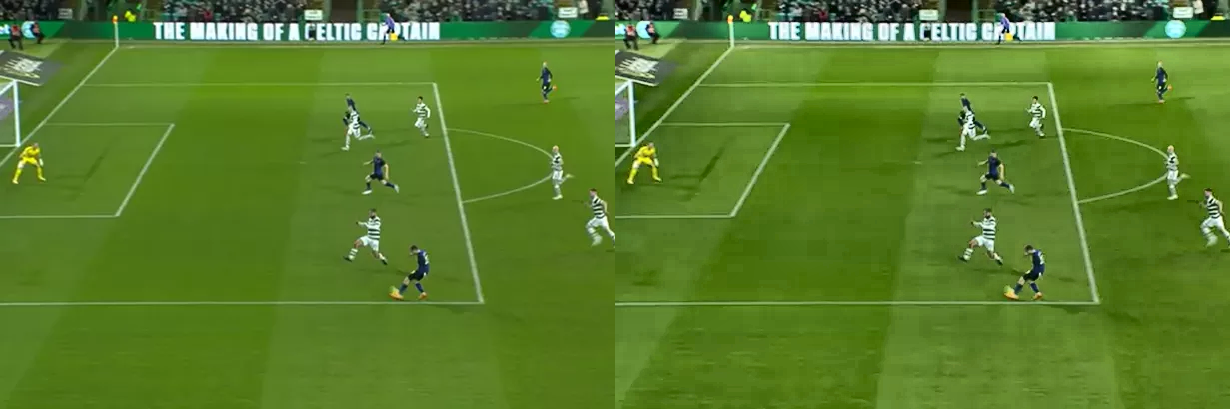


[2/7] Calculando homografía campo-imagen...
Homografía calculada

[3/7] Detectando jugadores con YOLO...
Ejecutando detección con conf=0.25...
Encontradas 13 detecciones totales
Clases detectadas:
Clase 2: 12 detecciones
Clase 3: 1 detecciones
Total detecciones: 13

Resumen de detección:
Total detecciones: 13
Confianza promedio: 0.67

[4/7] Mostrando jugadores detectados...
     (Aún sin clasificar por equipos)


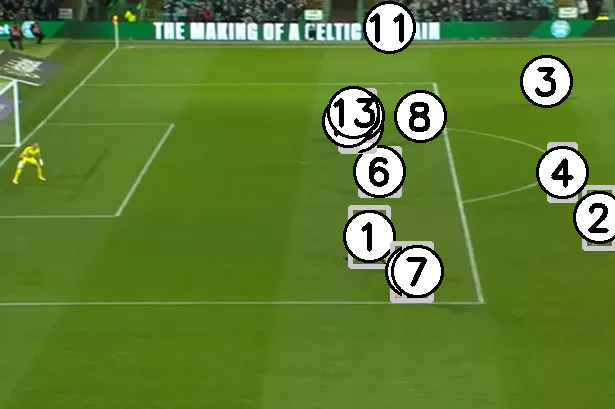


[5/7] Clasificando equipos con CLIP...

Clasificando equipos con CLIP...
Extrayendo features CLIP de 13 jugadores...
Clasificación CLIP: Equipo 0: 5, Equipo 1: 8
Usando clasificación CLIP

Mostrando jugadores clasificados por equipo...


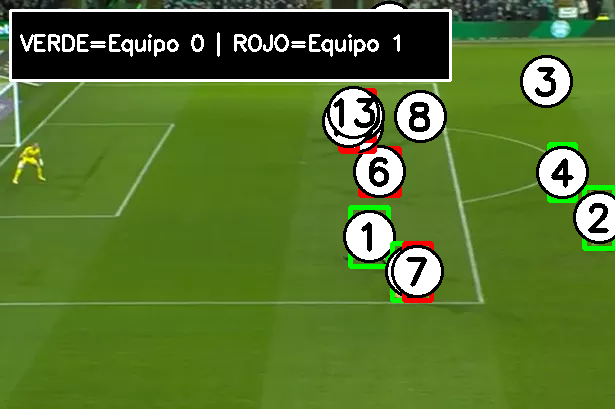

Equipo 0 (VERDE): 5 jugadores
Equipo 1 (ROJO): 8 jugadores

[6/7] Calculando posiciones en el campo...
Porteros identificados: 3
Jugadores de campo: 10

[7/7] Selección de línea de offside...
Número del jugador que marca offside (1-13): 12

Seleccionado: Jugador #12

Línea de offside en X = 59.60m
Basada en jugador #12

Analizando posiciones de offside...
Equipo defensor: 1
Equipo atacante: 0
Línea de offside en X = 59.60m
Dirección de ataque: ← (hacia X=0)

Verificando atacantes:
Jugador #1: X=63.10m  OK
Jugador #5: X=70.29m  OK
Jugador #8: X=71.91m  OK

Resultado: Ningún jugador en offside

Visualización final:


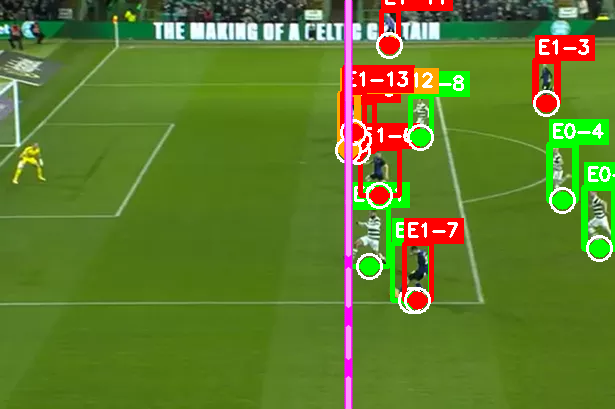


Estadísticas:
Total jugadores detectados: 13
  • Equipo 0: 5 jugadores
  • Equipo 1: 8 jugadores
  • Porteros: 3
Estado: No hay offside


In [ ]:
# Pipeline Principal

"""
Este es el pipeline principal que procesa cada imagen paso a paso:

PASO 1: Preprocesamiento - Mejora la calidad de la imagen
PASO 2: Homografía - Calcula la transformación perspectiva campo-imagen
PASO 3: Detección - Encuentra todos los jugadores con YOLO
PASO 4: Visualización inicial - Muestra jugadores numerados
PASO 5: Clasificación - Agrupa jugadores en equipos con CLIP
PASO 6: Posiciones - Calcula coordenadas reales en el campo
PASO 7: Selección manual - El usuario indica la línea de offside
PASO 8: Análisis - Determina qué jugadores están en offside
PASO 9: Resultado final - Genera visualización completa

El proceso es interactivo: te mostrará las imágenes y te pedirá seleccionar
el jugador que marca la línea de offside.
"""


import matplotlib.pyplot as plt
import seaborn as sns

preprocessor = ImagePreprocessor()
detector = PlayerDetector()
homography = Homography()
classifier = CLIPTeamClassifier()

for img_name in sorted(os.listdir("/content/images")):
    if not img_name.lower().endswith(".png"):
        continue

    print(f"Procesando: {img_name}")

    frame_original = cv2.imread(f"/content/images/{img_name}")
    if frame_original is None:
        print("Error cargando imagen")
        continue


    print("\n[1/7] Preprocesamiento de imagen...")
    frame_enhanced = preprocessor.enhance_adaptive(frame_original)

    print("Comparación original vs procesada:")
    comparison = preprocessor.show_comparison(frame_original, frame_enhanced)
    cv2_imshow(comparison)

    frame = frame_enhanced


    print("\n[2/7] Calculando homografía campo-imagen...")
    H, mask = homography.estimate_from_grass_kmeans(frame, verbose=True)
    if H is None:
        print("Error: homografía falló, saltando imagen")
        continue


    print("\n[3/7] Detectando jugadores con YOLO...")
    persons = detector.detect(frame, conf=0.25)

    print(f"\nResumen de detección:")
    print(f"Total detecciones: {len(persons)}")

    if len(persons) > 0:
        confidences = [p['conf'] for p in persons]
        print(f"Confianza promedio: {np.mean(confidences):.2f}")


    if len(persons) < 4:
        print(f"\nMuy pocas detecciones ({len(persons)})")
        print("Intenta reducir la confianza (ej: conf=0.15)")
        continue


        print(f"\nEstadísticas de confianza:")
        print(f"Media: {np.mean(confidences):.3f}")
        print(f"Mediana: {np.median(confidences):.3f}")
        print(f"Desviación estándar: {np.std(confidences):.3f}")
        print(f"Mínimo: {min(confidences):.3f}")
        print(f"Máximo: {max(confidences):.3f}")


    print("\n[4/7] Mostrando jugadores detectados...")
    print("     (Aún sin clasificar por equipos)")

    initial_vis = show_numbered_players(frame_original, persons, team_labels=None)
    cv2_imshow(initial_vis)


    print("\n[5/7] Clasificando equipos con CLIP...")
    jersey_patches = [detector.extract_jersey_patch(frame, p['xyxy']) for p in persons]
    team_labels = classifier.classify_teams(jersey_patches, verbose=True)

    if team_labels is not None:
        print("\nMostrando jugadores clasificados por equipo...")
        classified_vis = show_numbered_players(frame_original, persons, team_labels)
        cv2_imshow(classified_vis)

        team0_count = np.sum(np.array(team_labels) == 0)
        team1_count = np.sum(np.array(team_labels) == 1)
        print(f"Equipo 0 (VERDE): {team0_count} jugadores")
        print(f"Equipo 1 (ROJO): {team1_count} jugadores")






        team0_patches = [jersey_patches[i] for i in range(len(team_labels)) if team_labels[i] == 0 and jersey_patches[i].size > 0]
        team1_patches = [jersey_patches[i] for i in range(len(team_labels)) if team_labels[i] == 1 and jersey_patches[i].size > 0]



    print("\n[6/7] Calculando posiciones en el campo...")

    feet_positions = []
    field_positions = []

    for player in persons:
        feet = detector.get_player_feet(frame, player['xyxy'])
        feet_positions.append(feet)
        field_pos = homography.image_to_field([feet])
        field_positions.append(field_pos[0] if field_pos is not None else [52.5, 34.0])


    identify_goalkeepers(persons, field_positions)

    n_goalkeepers = sum(1 for p in persons if p.get('is_goalkeeper', False))
    print(f"Porteros identificados: {n_goalkeepers}")
    print(f"Jugadores de campo: {len(persons) - n_goalkeepers}")



    print("\n[7/7] Selección de línea de offside...")
    offside_player_idx = get_offside_player_input(len(persons))
    offside_x = field_positions[offside_player_idx][0]

    print(f"\nLínea de offside en X = {offside_x:.2f}m")
    print(f"Basada en jugador #{offside_player_idx + 1}")


    offside_players_list = check_offside_players(persons, field_positions, offside_x,
                                                   offside_player_idx, team_labels)


    result = draw_final_result(frame_original, persons, feet_positions, team_labels,
                               offside_player_idx, offside_x, homography.H,
                              offside_players_list)

    print("\nVisualización final:")
    cv2_imshow(result)


    print("\nEstadísticas:")
    print(f"Total jugadores detectados: {len(persons)}")
    if team_labels is not None:
        team0_count = np.sum(np.array(team_labels) == 0)
        team1_count = np.sum(np.array(team_labels) == 1)
        print(f"  • Equipo 0: {team0_count} jugadores")
        print(f"  • Equipo 1: {team1_count} jugadores")
    print(f"  • Porteros: {n_goalkeepers}")

    if len(offside_players_list) > 0:
        print(f"Estado: Offside Detectado")
    else:
        print(f"Estado: No hay offside")


Imagen con jugadores numerados:


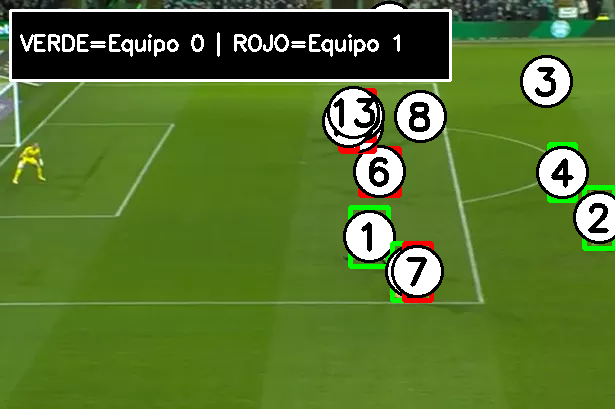


Se detectaron 13 jugadores numerados del 1 al 13

Clases disponibles:
0 = Equipo 0
1 = Equipo 1
2 = Portero
3 = Arbitro
4 = No-Jugador (staff, abanderado, etc.)


Para cada jugador, ingresa el número de su clase real:

Jugador #1 - Modelo predijo: Equipo0 (Verde)
¿Qué es realmente? (0/1/2/3/4): 0
Registrado como: Equipo0

Jugador #2 - Modelo predijo: Equipo0 (Verde)
¿Qué es realmente? (0/1/2/3/4): 0
Registrado como: Equipo0

Jugador #3 - Modelo predijo: Equipo1 (Rojo)
¿Qué es realmente? (0/1/2/3/4): 1
Registrado como: Equipo1

Jugador #4 - Modelo predijo: Equipo0 (Verde)
¿Qué es realmente? (0/1/2/3/4): 0
Registrado como: Equipo0

Jugador #5 - Modelo predijo: Equipo0 (Verde)
¿Qué es realmente? (0/1/2/3/4): 0
Registrado como: Equipo0

Jugador #6 - Modelo predijo: Equipo1 (Rojo)
¿Qué es realmente? (0/1/2/3/4): 1
Registrado como: Equipo1

Jugador #7 - Modelo predijo: Equipo1 (Rojo)
¿Qué es realmente? (0/1/2/3/4): 1
Registrado como: Equipo1

Jugador #8 - Modelo predijo: Equipo0 (Verde)
¿Qu

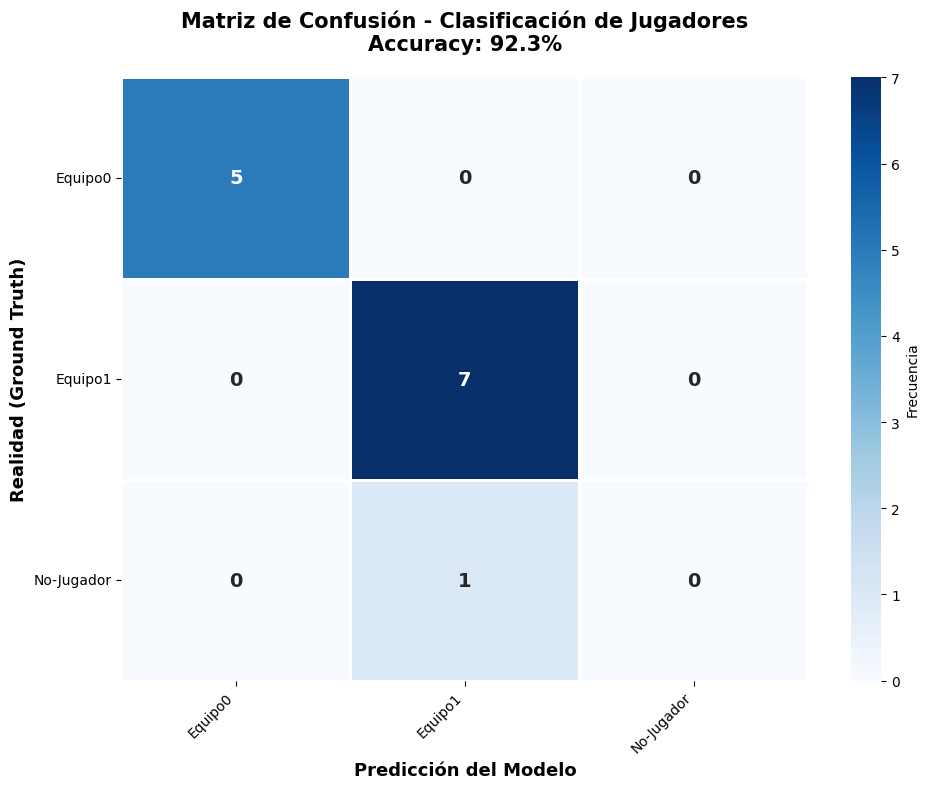

In [ ]:

"""

Esta celda usa las detecciones y clasificaciones que ya tienes del pipeline anterior.
Solo necesitas ver la imagen con números y decir qué es realmente cada jugador.

Usa las variables que ya existen:
- frame_original: tu imagen
- persons: detecciones de YOLO
- team_labels: lo que CLIP predijo
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def create_confusion_matrix_interactive(frame_original, persons, team_labels):
    """
    Crea matriz de confusión permitiéndote indicar manualmente la verdad

    Usa las variables que ya tienes del pipeline principal
    """


    # Mostrar imagen con números (ya tienes esta función)
    numbered_img = show_numbered_players(frame_original, persons, team_labels)
    print("Imagen con jugadores numerados:")
    cv2_imshow(numbered_img)


    print()
    print(f"Se detectaron {len(persons)} jugadores numerados del 1 al {len(persons)}")
    print()
    print("Clases disponibles:")
    print("0 = Equipo 0")
    print("1 = Equipo 1")
    print("2 = Portero")
    print("3 = Arbitro")
    print("4 = No-Jugador (staff, abanderado, etc.)")
    print()
    print("="*70)
    print()

    # Definir clases
    class_names = ['Equipo0', 'Equipo1', 'Portero', 'Arbitro', 'No-Jugador']

    # Recolectar ground truth manualmente
    ground_truth = []

    print("Para cada jugador, ingresa el número de su clase real:")
    print()

    for i in range(len(persons)):
        while True:
            try:
                # Mostrar qué predijo el modelo
                if team_labels is not None and i < len(team_labels):
                    if team_labels[i] == 0:
                        pred = "Equipo0 (Verde)"
                    elif team_labels[i] == 1:
                        pred = "Equipo1 (Rojo)"
                    else:
                        pred = "Sin clasificar"
                    print(f"Jugador #{i+1} - Modelo predijo: {pred}")
                else:
                    print(f"Jugador #{i+1}")

                respuesta = input(f"¿Qué es realmente? (0/1/2/3/4): ").strip()
                clase = int(respuesta)

                if 0 <= clase <= 4:
                    ground_truth.append(clase)
                    print(f"Registrado como: {class_names[clase]}")
                    print()
                    break
                else:
                    print("Debe ser un número entre 0 y 4")
            except ValueError:
                print("Ingresa solo un número (0, 1, 2, 3 o 4)")
            except KeyboardInterrupt:
                print("Cancelado por el usuario")
                return None


    # Convertir predicciones del modelo a formato compatible
    # Ajustar según tu modelo (CLIP da 0 o 1, agregamos categorías extra como -1)
    predictions = []
    for i in range(len(persons)):
        if team_labels is not None and i < len(team_labels):
            if team_labels[i] >= 0:
                predictions.append(team_labels[i])  # 0 o 1
            else:
                predictions.append(4)  # Sin clasificar → No-Jugador
        else:
            predictions.append(4)  # Si no hay label, asumir No-Jugador

    # Filtrar clases que realmente aparecen
    unique_gt = sorted(set(ground_truth))
    unique_pred = sorted(set(predictions))
    all_classes = sorted(set(unique_gt + unique_pred))
    active_class_names = [class_names[i] for i in all_classes]

    # Mapear a índices contiguos para sklearn
    class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(all_classes)}
    ground_truth_mapped = [class_mapping[gt] for gt in ground_truth]
    predictions_mapped = [class_mapping[pred] for pred in predictions]

    # Crear matriz de confusión
    cm = confusion_matrix(ground_truth_mapped, predictions_mapped)

    print("Matriz de Confusión:")
    print()
    print("           ", "  ".join(f"{name:12s}" for name in active_class_names))
    for i, row in enumerate(cm):
        print(f"{active_class_names[i]:12s}", "  ".join(f"{val:12d}" for val in row))
    print()

    # Calcular métricas
    total = np.sum(cm)
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print(f"Presición Global: {accuracy:.1%} ({correct}/{total} correctos)")
    print()


    # Visualizar
    print("Generando visualización...")
    plot_confusion_matrix_final(cm, active_class_names, accuracy)

    # Guardar resultados
    results = {
        'ground_truth': ground_truth,
        'predictions': predictions,
        'confusion_matrix': cm.tolist(),
        'class_names': active_class_names,
        'accuracy': accuracy
    }

    return results


def plot_confusion_matrix_final(cm, class_names, accuracy):
    """
    Visualiza la matriz de confusión final
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Crear heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Frecuencia'},
                ax=ax,
                annot_kws={"size": 14, "weight": "bold"},
                linewidths=2, linecolor='white')

    ax.set_xlabel('Predicción del Modelo', fontsize=13, fontweight='bold')
    ax.set_ylabel('Realidad (Ground Truth)', fontsize=13, fontweight='bold')
    ax.set_title(f'Matriz de Confusión - Clasificación de Jugadores\nAccuracy: {accuracy:.1%}',
                fontsize=15, fontweight='bold', pad=20)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
    print("✓ Matriz guardada en: confusion_matrix_final.png")
    plt.show()



results = create_confusion_matrix_interactive(
    frame_original,  # Tu imagen original
    persons,         # Detecciones de YOLO
    team_labels      # Clasificación de CLIP
)
